# Creating Carbon Dioxide Removal (CDR) Forcing

`ROMS-Tools` supports two types of Carbon Dioxide Removal (CDR) forcing:

- **`VolumeSourceWithTracers`**: Simulates point sources of water and tracers introduced at specific locations (e.g., through a pipe).
  - Useful for field-scale experiments where initial mixing is important.
  - Injects both water and tracers at specific points.
  - Requires all 32 BGC tracers, plus temperature and salinity.

- **`TracerPerturbation`**: Modifies existing tracer fields without introducing any water (no volume flux).  
  - Suitable for larger-scale simulations where initial mixing is assumed.
  - Only the specified tracers are perturbed; others remain unchanged.
 
This notebook demonstrates how to use these two CDR forcing classes in `ROMS-Tools`.

In [1]:
from roms_tools import Grid
from datetime import datetime

Let's create our CDR forcings for the following grid.

In [2]:
grid = Grid(
    nx=250,
    ny=250,
    size_x=2500,
    size_y=2500,
    center_lon=-15,
    center_lat=65,
    rot=-30,
    N=100,
)

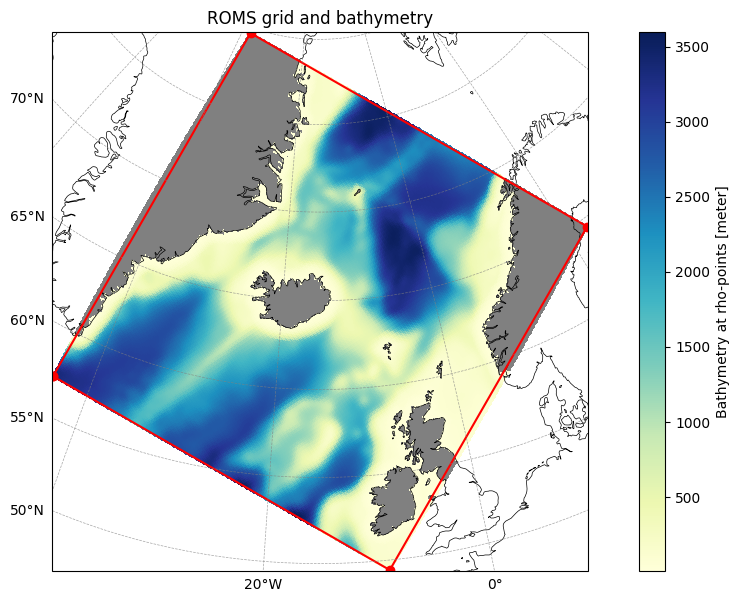

In [3]:
grid.plot()

## Volume Source with Tracers

In [4]:
from roms_tools import VolumeSourceWithTracers

In [5]:
cdr_forcing = VolumeSourceWithTracers(
    grid=grid, start_time=datetime(2010, 1, 1), end_time=datetime(2012, 1, 1)
)

In [6]:
cdr_forcing.ds

<xarray.Dataset> Size: 9kB
Dimensions:           (time: 0, ncdr: 0, ntracers: 34)
Coordinates:
  * time              (time) float64 0B 
    release_name      (ncdr) <U1 0B 
    tracer_name       (ntracers) <U11 1kB 'temp' 'salt' ... 'diazP' 'diazFe'
    tracer_unit       (ntracers) <U15 2kB 'degrees Celsius' 'PSU' ... 'mmol/m^3'
    tracer_long_name  (ntracers) <U43 6kB 'potential temperature' ... 'diazot...
Dimensions without coordinates: ncdr, ntracers
Data variables:
    cdr_time          (time) float64 0B 
    cdr_lon           (ncdr) float64 0B 
    cdr_lat           (ncdr) float64 0B 
    cdr_dep           (ncdr) float64 0B 
    cdr_hsc           (ncdr) float64 0B 
    cdr_vsc           (ncdr) float64 0B 
    cdr_volume        (time, ncdr) float64 0B 
    cdr_tracer        (time, ntracers, ncdr) float64 0B

### Adding a constant release over the full simulation period

In [7]:
cdr_forcing.add_release(
    name="Iceland_field_trial",
    lat=65.0,
    lon=-25,
    depth=10,
    volume_fluxes=1000,
    tracer_concentrations={"temp": 20.0, "salt": 1.0, "ALK": 2000.0},
)

In [8]:
cdr_forcing.ds

<xarray.Dataset> Size: 10kB
Dimensions:           (time: 2, ntracers: 34, ncdr: 1)
Coordinates:
  * time              (time) datetime64[ns] 16B 2010-01-01 2012-01-01
    tracer_name       (ntracers) <U11 1kB 'temp' 'salt' ... 'diazP' 'diazFe'
    tracer_unit       (ntracers) <U15 2kB 'degrees Celsius' 'PSU' ... 'mmol/m^3'
    tracer_long_name  (ntracers) <U43 6kB 'potential temperature' ... 'diazot...
    release_name      (ncdr) <U19 76B 'Iceland_field_trial'
Dimensions without coordinates: ntracers, ncdr
Data variables:
    cdr_time          (time) float64 16B 3.653e+03 4.383e+03
    cdr_lon           (ncdr) float64 8B -25.0
    cdr_lat           (ncdr) float64 8B 65.0
    cdr_dep           (ncdr) float64 8B 10.0
    cdr_hsc           (ncdr) float64 8B 0.0
    cdr_vsc           (ncdr) float64 8B 0.0
    cdr_volume        (time, ncdr) float64 16B 1e+03 1e+03
    cdr_tracer        (time, ntracers, ncdr) float64 544B 20.0 1.0 ... 1.5e-06

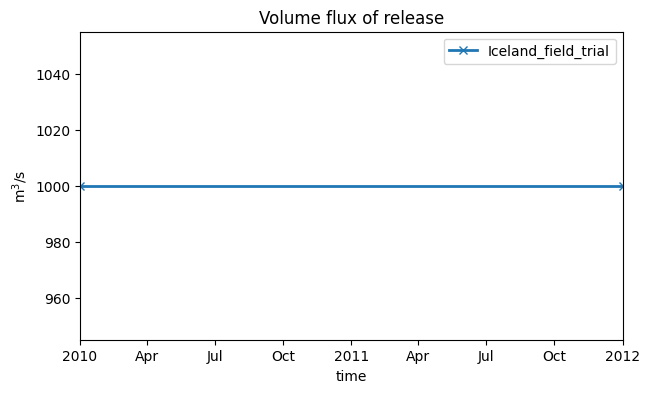

In [9]:
cdr_forcing.plot_volume_flux()

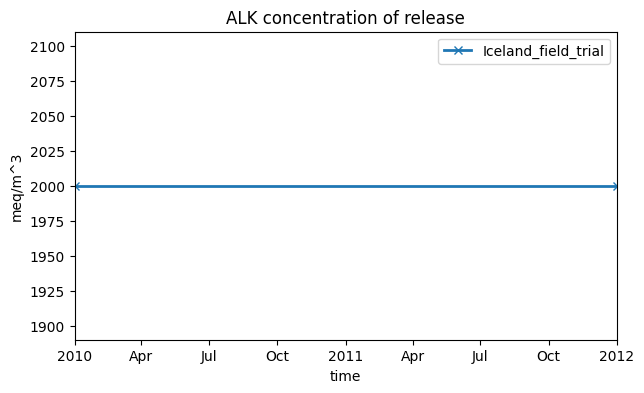

In [10]:
cdr_forcing.plot_tracer_concentration("ALK")

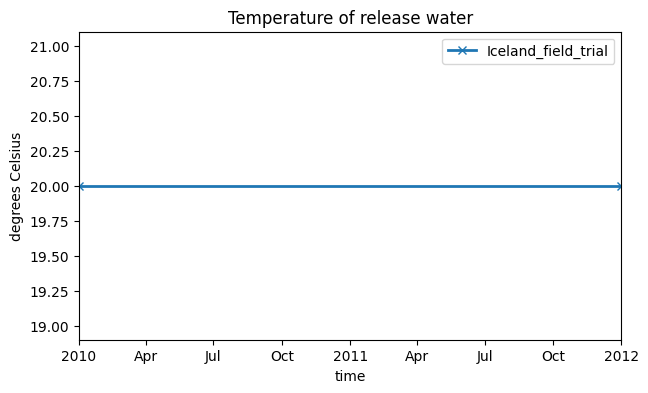

In [11]:
cdr_forcing.plot_tracer_concentration("temp")

### Adding time-varying releases

In [12]:
cdr_forcing.add_release(
    name="Greenland_field_trial",
    lat=70,
    lon=-20,
    depth=100,
    times=[
        datetime(2011, 1, 15, 12, 0),
        datetime(2011, 1, 15, 15, 0), 
        datetime(2011, 1, 15, 18, 0), 
        datetime(2011, 1, 15, 21, 0), 
        datetime(2011, 1, 22, 3, 0), 
        datetime(2011, 1, 22, 6, 0), 
        datetime(2011, 1, 22, 9, 0),
        datetime(2011, 1, 22, 12, 0),
    ],
        
    volume_fluxes=[
        0, 
        100,
        500,
        1000, 
        1000,
        500,
        100,
        0
    ],
    tracer_concentrations={
        "ALK": [
            2000.0, 
            2100.0,
            2100.0,
            2100.0,
            2100.0,
            2100.0,
            2100.0,
            2000.0,
        ],
        "temp": 20.0, 
        "salt": 1.0
    },
)

In [13]:
cdr_forcing.ds

<xarray.Dataset> Size: 15kB
Dimensions:           (time: 10, ntracers: 34, ncdr: 2)
Coordinates:
  * time              (time) datetime64[ns] 80B 2010-01-01 ... 2012-01-01
    tracer_name       (ntracers) <U11 1kB 'temp' 'salt' ... 'diazP' 'diazFe'
    tracer_unit       (ntracers) <U15 2kB 'degrees Celsius' 'PSU' ... 'mmol/m^3'
    tracer_long_name  (ntracers) <U43 6kB 'potential temperature' ... 'diazot...
    release_name      (ncdr) <U21 168B 'Iceland_field_trial' 'Greenland_field...
Dimensions without coordinates: ntracers, ncdr
Data variables:
    cdr_time          (time) float64 80B 3.653e+03 4.032e+03 ... 4.383e+03
    cdr_lon           (ncdr) float64 16B -25.0 -20.0
    cdr_lat           (ncdr) float64 16B 65.0 70.0
    cdr_dep           (ncdr) float64 16B 10.0 100.0
    cdr_hsc           (ncdr) float64 16B 0.0 0.0
    cdr_vsc           (ncdr) float64 16B 0.0 0.0
    cdr_volume        (time, ncdr) float64 160B 1e+03 0.0 1e+03 ... 1e+03 0.0
    cdr_tracer        (time, ntracers, ncdr) float64 5kB 20.0 20.0 ... 1.5e-06

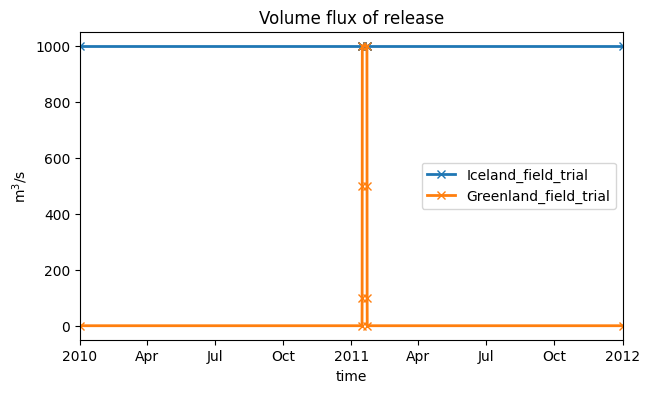

In [14]:
cdr_forcing.plot_volume_flux()

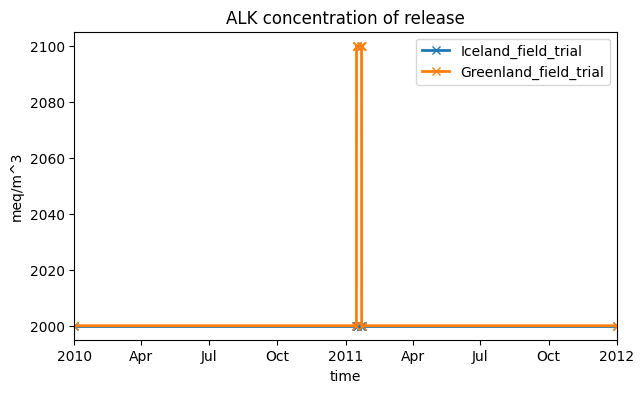

In [15]:
cdr_forcing.plot_tracer_concentration("ALK")

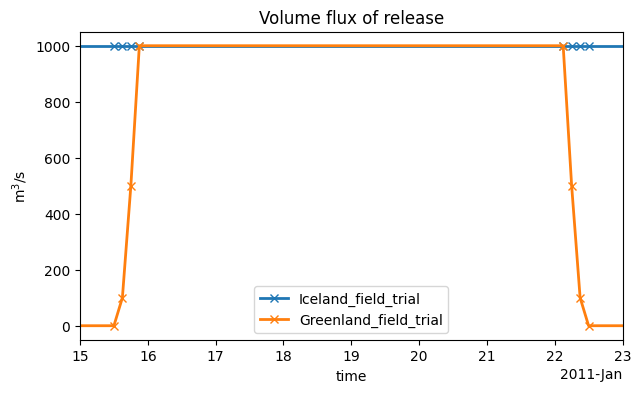

In [16]:
cdr_forcing.plot_volume_flux(start=datetime(2011, 1, 15), end=datetime(2011, 1, 23))

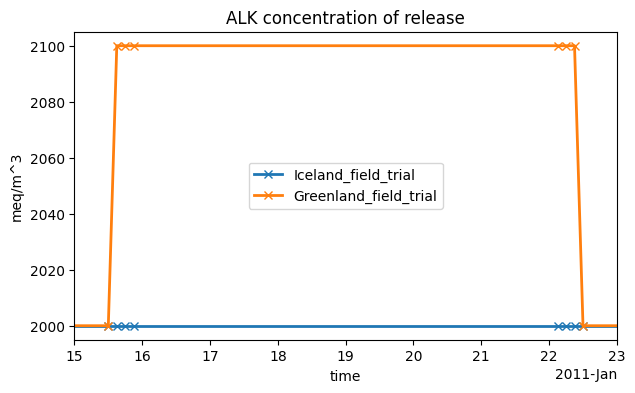

In [17]:
cdr_forcing.plot_tracer_concentration("ALK", start=datetime(2011, 1, 15), end=datetime(2011, 1, 23))

In [18]:
cdr_forcing.add_release(
    name="another_Greenland_field_trial",
    lat=73,
    lon=-20,
    depth=100,
    times=[
        datetime(2011, 1, 15, 15, 0), 
        datetime(2011, 1, 15, 18, 0), 
        datetime(2011, 1, 15, 21, 0), 
        datetime(2011, 1, 22, 3, 0), 
        datetime(2011, 1, 22, 6, 0), 
        datetime(2011, 1, 22, 9, 0),
    ],
        
    volume_fluxes=[
        100,
        500,
        1000, 
        1000,
        500,
        100,
    ],
    tracer_concentrations={
        "ALK": [
            2100.0,
            2100.0,
            2100.0,
            2100.0,
            2100.0,
            2100.0,
        ],
        "temp": 20.0, 
        "salt": 1.0
    },
)

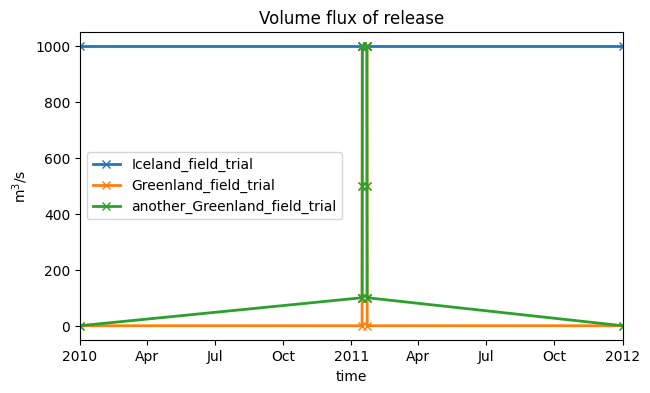

In [19]:
cdr_forcing.plot_volume_flux()

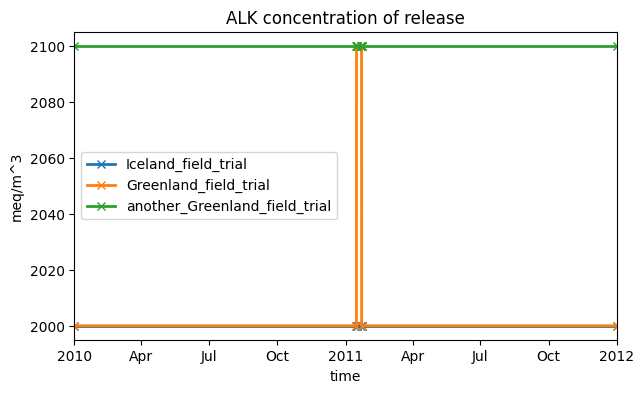

In [20]:
cdr_forcing.plot_tracer_concentration("ALK")

### Auto-fill vs. zero-fill



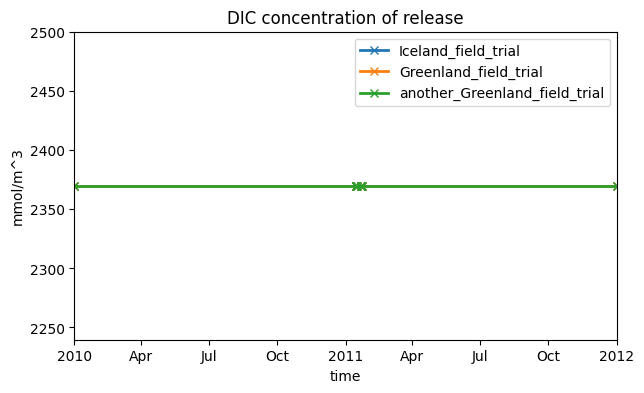

In [21]:
cdr_forcing.plot_tracer_concentration("DIC")

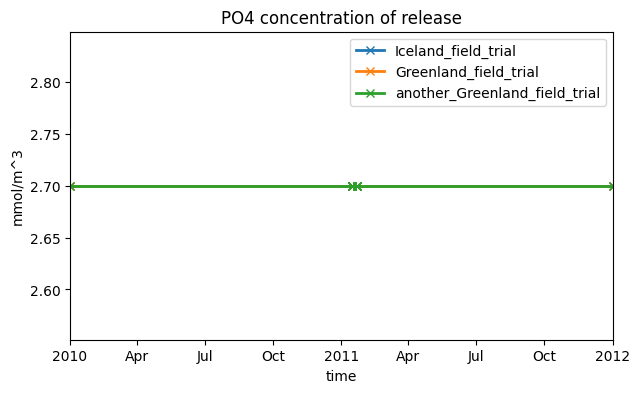

In [32]:
cdr_forcing.plot_tracer_concentration("PO4")

In [34]:
cdr_forcing.ds

<xarray.Dataset> Size: 18kB
Dimensions:           (time: 10, ntracers: 34, ncdr: 3)
Coordinates:
  * time              (time) datetime64[ns] 80B 2010-01-01 ... 2012-01-01
    tracer_name       (ntracers) <U11 1kB 'temp' 'salt' ... 'diazP' 'diazFe'
    tracer_unit       (ntracers) <U15 2kB 'degrees Celsius' 'PSU' ... 'mmol/m^3'
    tracer_long_name  (ntracers) <U43 6kB 'potential temperature' ... 'diazot...
    release_name      (ncdr) <U29 348B 'Iceland_field_trial' ... 'another_Gre...
Dimensions without coordinates: ntracers, ncdr
Data variables:
    cdr_time          (time) float64 80B 3.653e+03 4.032e+03 ... 4.383e+03
    cdr_lon           (ncdr) float64 24B -25.0 -20.0 -20.0
    cdr_lat           (ncdr) float64 24B 65.0 70.0 73.0
    cdr_dep           (ncdr) float64 24B 10.0 100.0 100.0
    cdr_hsc           (ncdr) float64 24B 0.0 0.0 0.0
    cdr_vsc           (ncdr) float64 24B 0.0 0.0 0.0
    cdr_volume        (time, ncdr) float64 240B 1e+03 0.0 0.0 ... 1e+03 0.0 0.0
    cdr_tracer        (time, ntracers, ncdr) float64 8kB 20.0 20.0 ... 1.5e-06

In [35]:
cdr_forcing.add_release(    
    name="Iceland_field_trial_with_zero_fill",
    lat=65.0,
    lon=-25,
    depth=10,
    volume_fluxes=1000,
    tracer_concentrations={"temp": 20.0, "salt": 1.0, "ALK": 2000.0},
    fill_values="zero_fill"
)

ValueError: A release with the name 'Iceland_field_trial_with_zero_fill' already exists.

### Plotting the release locations

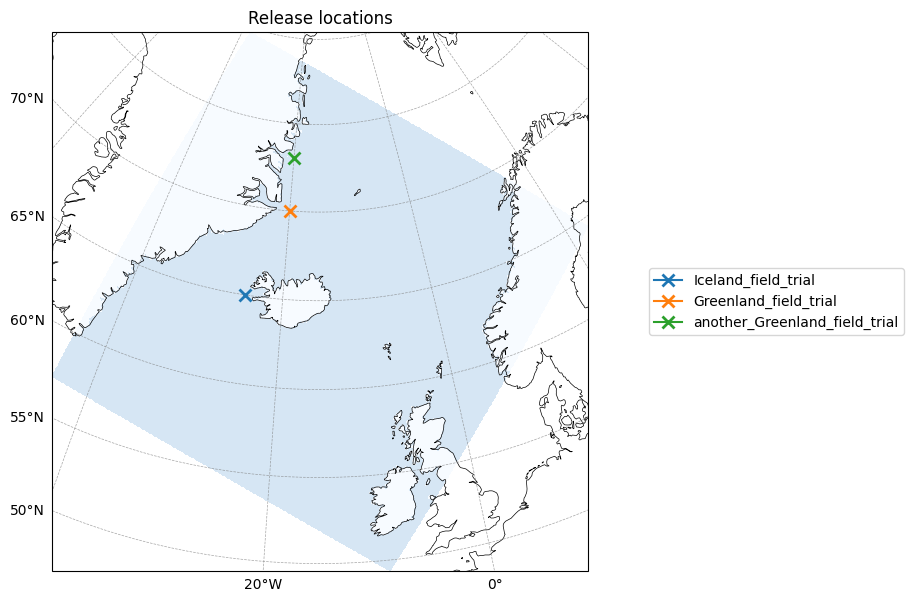

In [21]:
cdr_forcing.plot_location_top_view()

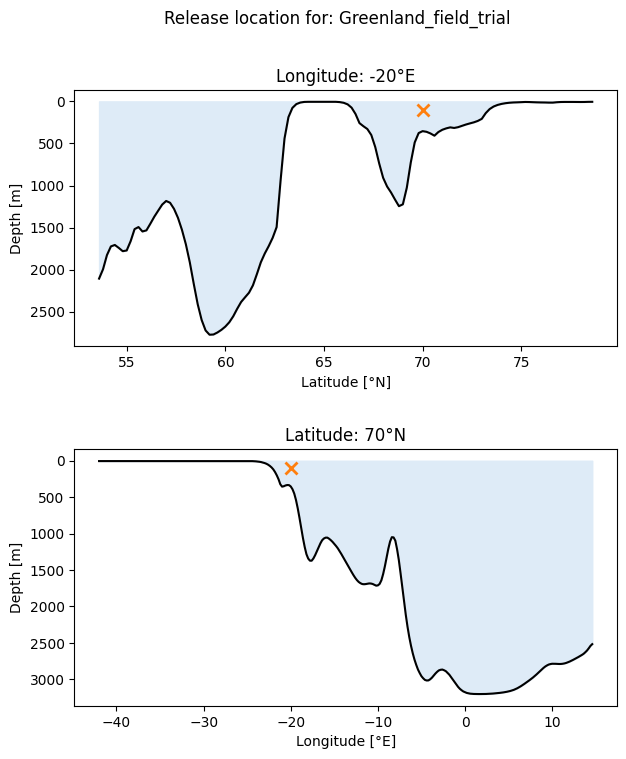

In [22]:
cdr_forcing.plot_location_side_view("Greenland_field_trial")

### Saving as NetCDF or YAML file

In [25]:
yaml_filepath = "/glade/derecho/scratch/noraloose/forcing/my_cdr_forcing.yaml"

In [26]:
cdr_forcing.to_yaml(yaml_filepath)

This is the YAML file that was created.

In [30]:
cdr_forcing.releases["Iceland_field_trial"]

{'lat': 65.0,
 'lon': -25,
 'depth': 10,
 'times': [datetime.datetime(2010, 1, 1, 0, 0),
  datetime.datetime(2012, 1, 1, 0, 0)],
 'volume_fluxes': 1000,
 'tracer_concentrations': {'temp': 20.0,
  'salt': 1.0,
  'ALK': 2000.0,
  'PO4': 2.7,
  'NO3': 24.2,
  'SiO3': 13.2,
  'NH4': 2.2,
  'Fe': 1.79,
  'Lig': 5.37,
  'O2': 187.5,
  'DIC': 2370.0,
  'DIC_ALT_CO2': 2370.0,
  'ALK_ALT_CO2': 2310.0,
  'DOC': 0.0001,
  'DON': 1.0,
  'DOP': 0.1,
  'DOPr': 0.003,
  'DONr': 0.8,
  'DOCr': 1e-06,
  'zooC': 2.7,
  'spChl': 1.35,
  'spC': 6.75,
  'spP': 0.045,
  'spFe': 2.7e-05,
  'spCaCO3': 0.135,
  'diatChl': 0.135,
  'diatC': 0.405,
  'diatP': 0.03,
  'diatFe': 2.7e-06,
  'diatSi': 0.135,
  'diazChl': 0.015,
  'diazC': 0.075,
  'diazP': 0.015,
  'diazFe': 1.5e-06}}

In [28]:
cdr_forcing.releases

{'_tracer_metadata': {'temp': {'units': 'degrees Celsius',
   'long_name': 'potential temperature'},
  'salt': {'units': 'PSU', 'long_name': 'salinity'},
  'PO4': {'units': 'mmol/m^3', 'long_name': 'dissolved inorganic phosphate'},
  'NO3': {'units': 'mmol/m^3', 'long_name': 'dissolved inorganic nitrate'},
  'SiO3': {'units': 'mmol/m^3', 'long_name': 'dissolved inorganic silicate'},
  'NH4': {'units': 'mmol/m^3', 'long_name': 'dissolved ammonia'},
  'Fe': {'units': 'mmol/m^3', 'long_name': 'dissolved inorganic iron'},
  'Lig': {'units': 'mmol/m^3', 'long_name': 'iron binding ligand'},
  'O2': {'units': 'mmol/m^3', 'long_name': 'dissolved oxygen'},
  'DIC': {'units': 'mmol/m^3', 'long_name': 'dissolved inorganic carbon'},
  'DIC_ALT_CO2': {'units': 'mmol/m^3',
   'long_name': 'dissolved inorganic carbon, alternative CO2'},
  'ALK': {'units': 'meq/m^3', 'long_name': 'alkalinity'},
  'ALK_ALT_CO2': {'units': 'meq/m^3',
   'long_name': 'alkalinity, alternative CO2'},
  'DOC': {'units': 'mm

In [27]:
# Open and read the YAML file
with open(yaml_filepath, "r") as file:
    file_contents = file.read()

# Print the contents
print(file_contents)

---
roms_tools_version: 0.1.dev165
---
Grid:
  nx: 250
  ny: 250
  size_x: 2500
  size_y: 2500
  center_lon: -15
  center_lat: 65
  rot: -30
  N: 100
  theta_s: 5.0
  theta_b: 2.0
  hc: 300.0
  topography_source:
    name: ETOPO5
  hmin: 5.0
VolumeSourceWithTracers:
  start_time: '2010-01-01T00:00:00'
  end_time: '2012-01-01T00:00:00'
  model_reference_date: '2000-01-01T00:00:00'
  releases:
    _tracer_metadata:
      temp:
        units: degrees Celsius
        long_name: potential temperature
      salt:
        units: PSU
        long_name: salinity
      PO4:
        units: mmol/m^3
        long_name: dissolved inorganic phosphate
      NO3:
        units: mmol/m^3
        long_name: dissolved inorganic nitrate
      SiO3:
        units: mmol/m^3
        long_name: dissolved inorganic silicate
      NH4:
        units: mmol/m^3
        long_name: dissolved ammonia
      Fe:
        units: mmol/m^3
        long_name: dissolved inorganic iron
      Lig:
        units: mmol/m^3
     

## Tracer Perturbation

Coming soon...